In [1]:
import numpy as np
import pandas as pd
import seaborn as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_scaled_error
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    ReducedForecaster,
    make_reduction,
)

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.utils.plotting import plot_series
import statsmodels.api as sm

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
sns.set(rc={'figure.figsize':(12,6)})

### Importing data

In [14]:
df = sm.datasets.macrodata.load_pandas()['data']

In [15]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Data overview

In [16]:
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + "-" + 'Q'+ str(int(x['quarter'])), axis=1)
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()

In [200]:
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()

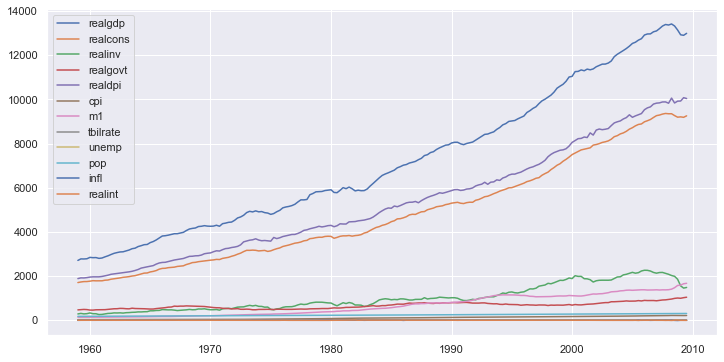

In [17]:
for val in df.columns[2:14]:
    plt.plot(df.date, df[val], label = val)
    plt.legend()

In [18]:
df = df.set_index('date').to_period("Q")

In [19]:
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

### Univariate time series


In [33]:
y = df['realgdp']

In [34]:
test_size = round(y.shape[0]*0.15)
test_size

30

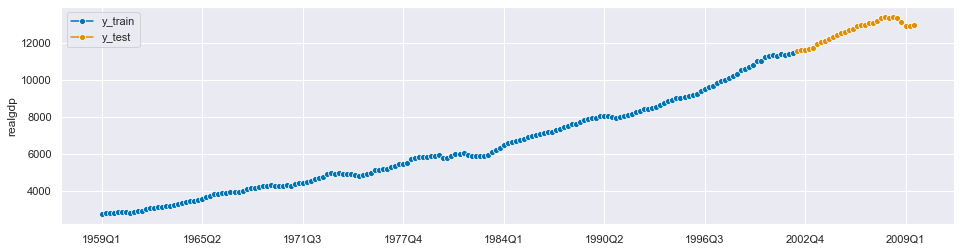

In [35]:
y_train, y_test = temporal_train_test_split(y, test_size=test_size)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [36]:
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)

In [37]:
fh_abs

ForecastingHorizon(['2002Q2', '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3',
             '2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3',
             '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1',
             '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', is_relative=False)

In [38]:
forecaster = AutoARIMA()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

3.2833435832045947

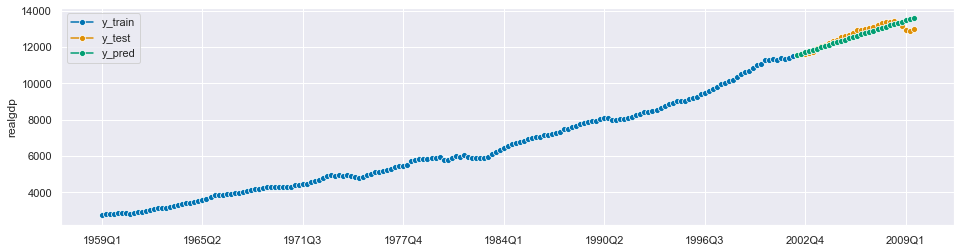

In [39]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_scaled_error(y_test, y_pred, y_train)

### Multivariate time series
Forecasting with extra regressors

In [40]:
y = df['realgdp']
X = df[['realinv']] #could be more features

In [41]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh_abs)

In [42]:
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train, fh=fh_abs)
y_pred = forecaster.predict(X=X_test)

2.3219398865377214

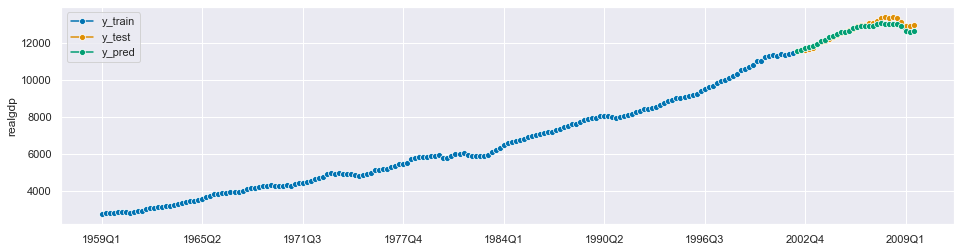

In [43]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_scaled_error(y_test, y_pred, y_train)

### Reduction

In [73]:
regressor = DecisionTreeRegressor()
# forecaster = make_reduction(regressor, window_length=14)
forecaster = ReducedForecaster(regressor, window_length=14)
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=DecisionTreeRegressor(),
                                     window_length=14)

In [74]:
y_pred = forecaster.predict(fh_abs)

18.723113917669735

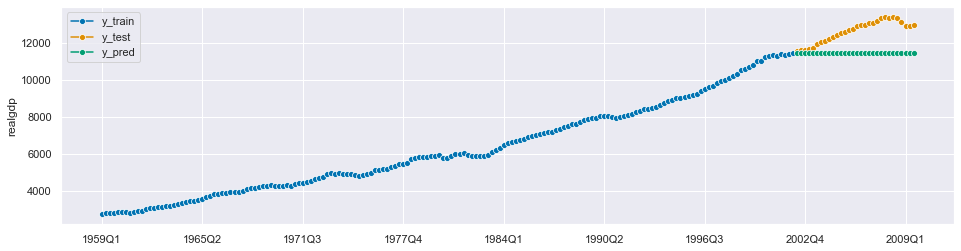

In [75]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_scaled_error(y_test, y_pred, y_train)